In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.signal import tf2zpk, zpk2tf, lfilter, freqz, dimpulse
from scipy.fftpack import fft
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

sns.set(style='ticks', font_scale=2)
blue, green, red, purple, gold, cyan = sns.color_palette("deep",6)

/Users/noahsilbert/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## A very brief review of FIR and IIR filters

Recall that a FIR filter can be expressed as an M-point moving average (with weights $h[k]$) of input signal $x[n]$ (and that the operation of multiplying the samples of the input signal by the weights and summing them up is called convolution):

$\displaystyle{y[n] = \sum_{k=0}^{M-1} h[k] x[n-k]} = h[k]\ast x[n]$

We can illustrate how a 5-point MA filter smooths out a signal that is the sum of three sinusoids:

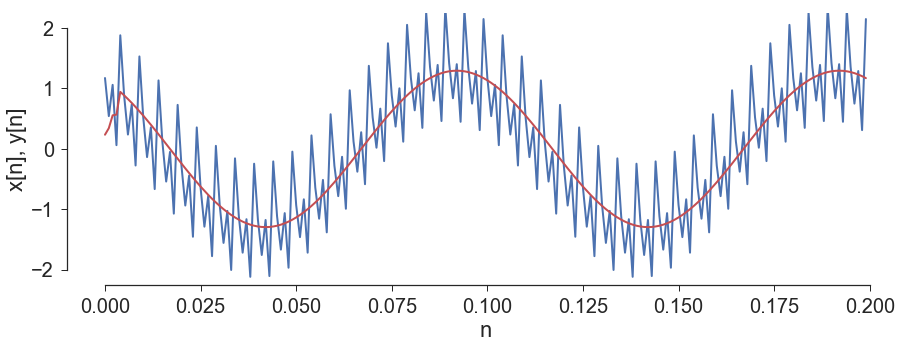

In [2]:
fs = 1000 # sampling frequency = 1000 Hz
t = np.arange(0,.2,1/fs) # time vector from 0 to 20 ms

# sinusoidal components
xa = 1.3*np.cos(2*np.pi*10*t + np.pi/5)
xb = 0.5*np.cos(2*np.pi*200*t + np.pi/4)
xc = 0.75*np.cos(2*np.pi*400*t + 3*np.pi/5)
x = xa + xb + xc

M = 5
hk = np.ones(M)/M
y1 = lfilter(a=1, b=hk, x=x)

# plotting
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(t,x, color=blue, lw=2)
ax.plot(t,y1, color=red, lw=2)
ax.set(ylim=(-2.25,2.25), xlabel='n', ylabel='x[n], y[n]')
sns.despine(ax=ax,trim=True)

Recall, too, that we can analyze FIR filters by taking the FFT of the coefficients (possibly after zero-padding the coefficient vector). This tells us which frequencies the filter passes and which frequencies it stops (among other things).

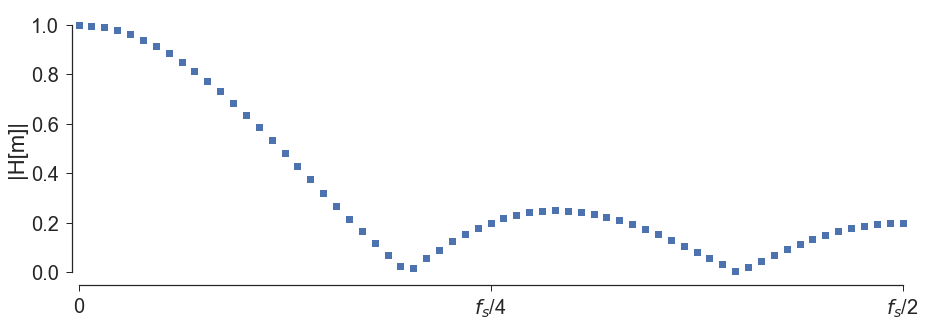

In [3]:
Npt = 128 # number of fft point
hkz = np.concatenate((hk,np.zeros(Npt-len(hk)))) # zero-padding coefficients hk
Hk = fft(hkz) # FFT of zero-padded hk

# plots
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(np.absolute(Hk[:int(Npt/2+1)]),'s'); 
ax.set(xlim=(-.5,Npt/2+.5),xticks=np.arange(0,Npt/2+1,Npt/4),
        xticklabels=['0','$f_s$/4','$f_s$/2'],ylim=(-.05,1.05),ylabel='|H[m]|')
_ = sns.despine(ax=ax,trim=True)

Recall that an IIR filter can be expressed as a moving average component and an auto-regressive component:

\begin{equation}
y[n] = \displaystyle{\sum_{k=1}^N a[k]y[n-k] + \sum_{k=0}^M b[k]x[n-k]}
\end{equation}

And if we take the $z$-transform (a generalization of the discrete Fourier transform) and rearrange terms, we get:

\begin{equation}
Y(z) = \displaystyle{\frac{\displaystyle{\sum_{k=0}^M} b[k]z^{-k}}{1-\displaystyle{\sum_{k=1}^N} a[k]z^{-k}}X(z)}
\end{equation}

So, we can express the transfer function of an IIR filter as:

\begin{equation}
H(z) = \frac{\displaystyle{\sum_{k=0}^M} b[k]z^{-k}}{1-\displaystyle{\sum_{k=1}^N} a[k]z^{-k}}
\end{equation}

This enables a more general method for analyzing filters than simply taking the DFT and analyzing the frequency response of a filter, as we did above with the 5-point FIR filter. The roots of the polynomial in the numerator of the transfer function are the filter's zeros, and the roots of the polynomial in the denominator are the filter's poles.

Here is a function from the week 5 notebook for making a pole-zero plot, a plot of the frequency response of the filter (the magnitude of the transfer function on the unit circle of the pole-zero plot), and the impulse response function (what the filter gives as output when the input is a single unit-magnitude sample):

In [4]:
def plot_filter(z,p,om,Hm,ir):
    fig = plt.figure(figsize=(18,4))
    gs = gridspec.GridSpec(1,5); ax1 = plt.subplot(gs[0,0]); ax2 = plt.subplot(gs[0,1:3]); ax3 = plt.subplot(gs[0,3:]);
    # create unit circle object
    circ = plt.Circle((0,0),1,color='k',ls='dashed',lw=2,fill=False)
    # make pole-zero plot in left panel
    ax1.set(ylim=(-1.5,1.5),xlim=(-1.5,1.5),xticks=[],yticks=[],aspect='equal');
    ax1.add_artist(circ); ax1.plot([-2,2],[0,0],'k:'); ax1.plot([0,0],[-2,2],'k:')
    [ax1.plot(zz.real,zz.imag,'ko',mfc='white',mec='black',ms=12,mew=2) for zz in z]
    [ax1.plot(pp.real,pp.imag,'kx',ms=12,mew=2) for pp in p]
    # plot |H(z)| in middle panel
    ax2.plot(om,Hm,lw=2)
    ax2.set(xlim=(-np.pi,np.pi),xticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],#ylabel='|H($e^{i\omega}$)|',
            xticklabels=[r'$-\pi$',r'$-\pi/2$','0',r'$\pi/2$',r'$\pi$'],yticks=[]);
    ax2.text(-np.pi,.75,'|H($e^{i\omega}$)|',fontsize=26)
    # plot h[n] - impulse response - in right panel
    ax3.stem(n,ir); ax3.set(xlim=(-1,20),xlabel='n',yticks=[])#,ylabel='h[n]')
    ax3.text(15,.75*ir.max(),'h[n]',fontsize=26)
    sns.despine(ax=ax2,trim=True, left=True); sns.despine(ax=ax3,trim=True, left=True)

And here are a couple IIR filters illustrated using this function:

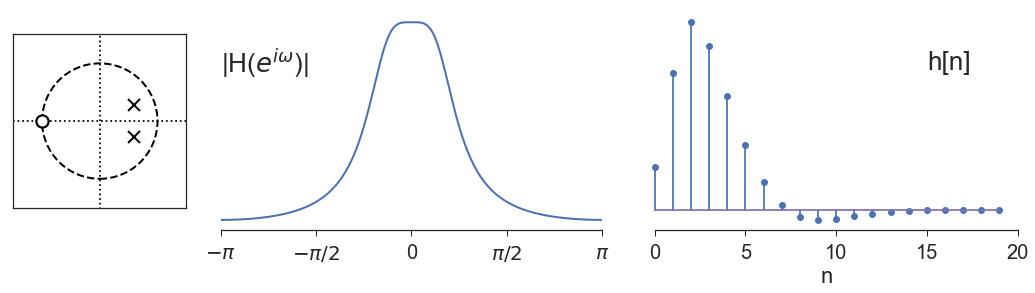

In [5]:
# filter coefficients
b = np.array([0.0605,0.121,0.0605])
a = np.array([1,-1.194,0.436])

# get magnitude spectrum
dpi = 2*np.pi/512
om = np.arange(-np.pi,np.pi,dpi) # frequency array
om,Hc = freqz(b,a,worN=om) # frequency response
Hm = np.absolute(Hc)
Hm = Hm/Hm.max()

# get poles, zeros, and gain from b, a
z,p,k = tf2zpk(b,a)

# time step, time array
dt = 1
n = np.arange(0,20,dt)

# get impulse response function
ir = dimpulse((z,p,k,dt),t=n,n=20)[1][0]

plot_filter(z=z,p=p,om=om,Hm=Hm,ir=ir)

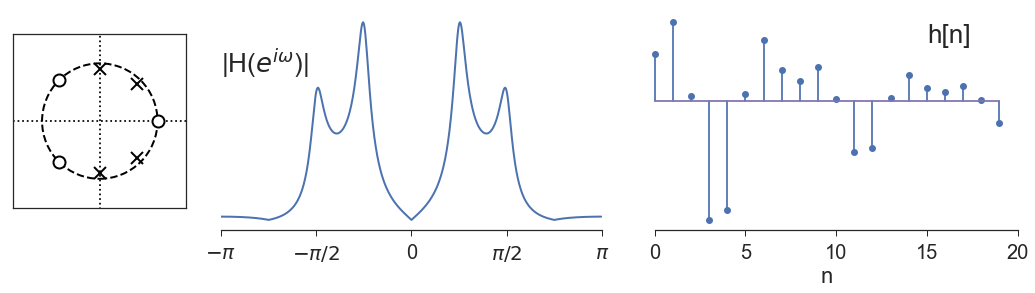

In [6]:
# complex poles (closer to unit circle), three zeros
p = np.array([.9*np.exp(1j*np.pi/4),.9*np.exp(-1j*np.pi/4),.9*np.exp(1j*np.pi/2),.9*np.exp(-1j*np.pi/2)])
z = np.array([1,1.0*np.exp(1j*3*np.pi/4),1.0*np.exp(-1j*3*np.pi/4)]); k = np.array([1])
#ir = dimpulse((z,p,k,dt),t=n,n=20)[1][0]

b,a = zpk2tf(z,p,k)
#print(b,a)
ir = lfilter(b,a,np.concatenate((np.ones(1),np.zeros(19))))
om,Hc = freqz(b,a,worN=om)
Hm = np.absolute(Hc)
Hm = Hm/Hm.max()

plot_filter(z=z,p=p,om=om,Hm=Hm,ir=ir)

## A very brief summary of linear regression

Linear regression models "predict" a *dependent* variable $\mathbf{y}$ (here a $n \times 1$ vector) by finding the best linear combination of *independent* variables $\mathbf{X}$ (here a $n \times p$ matrix). The word "predict" is in quotes here because the typical use of regression isn't really predicting anything, it's finding the best fit of the linear combination of $\mathbf{X}$ variables to the $y$ variable. Note that *best* here has a number of possible definitions. We'll return to this below.

There are a number of equivalent ways to write a linear regression model. One common way is to write an equation for the $i^{th}$ values of the $y$ and $\mathbf{X}$ variables plus some random error $\epsilon$:

$\displaystyle{y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip} + \epsilon_i = \beta_0 + \left(\sum_{j = 1}^p \beta_j x_{ij}\right) + \epsilon_i}$

If we make $x_{i0} = 1$, we can simplify this a bit:

$\displaystyle{y_i = \beta_0 x_{i0} + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip} + \epsilon_i = \left(\sum_{j = 0}^p \beta_j x_{ij}\right) + \epsilon_i}$

In order to completely specify this model, we need to say something about what, exactly, $\epsilon$ is. The $N$ instances of $\epsilon$ are typically taken to be independent, normally distributed random variables with mean (i.e., expected value) 0 and variance $\sigma^2$, which we can write as follows:

$\epsilon_i \sim \mathcal{N}(0,\sigma^2)$

This model can also be expressed in terms of the expected value of $y_i$, which is typically written $\hat{y}_i$:

$\displaystyle{\hat{y}_i = \beta_0 x_{i0} + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip} = \sum_{j = 0}^p \beta_j x_{ij}}$

Note that we've left $\epsilon$ out of this equation. In order to completely specify this model, we can write that $y$ is a random variable with expected value $\hat{y}$ and variance $\sigma^2$:

$y_i \sim \mathcal{N}(\hat{y}_i,\sigma^2)$

In Ordinary Least Squares (OLS) regression, the *best fit* of the model is the combination of independent variables such that the following expression is minimized (i.e., the sum of the squared deviations of the observed $y$ and the fitted $\hat{y}$ is as small as possible):

$\displaystyle{\sum_{i=1}^N \left(y_i - \left(\beta_0 + \sum_{j = 1}^p \beta_j x_{ij}\right)\right)^2}$

In maximum likelihood estimation, the *best fit* is given by the set of $\beta$ parameters that maximizes the (log) likelihood function:

$\displaystyle{f\left(\mathbf{y}|\boldsymbol{\beta},\sigma^2,\mathbf{X}\right) = \prod_{i=1}^N\frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(-\frac{(y_i-\hat{y}_i)^2}{2\sigma^2} \right)}$

For OLS regression, there are fairly simply mathematical equations that you can use to get the least squares/maximum likelihood $\beta$ estimates. For many (perhaps most) statistical models, it's not particularly simple to get best-fitting parameter estimates (and for most cases, the least squares estimates won't be equal to the maximum likelihood estimates).

As we discussed over the last two weeks, the `statsmodels` and `sklearn` modules make it easy to fit regression models. `statsmodels` has a [time-series analysis (sub-)module](http://www.statsmodels.org/dev/tsa.html).

## A very brief description of a general linear stochastic process

In the linear regression example above, observations $i$ and $j$ are assumed to be independent of one another. Hence, the order of the observations doesn't matter (i.e., if you switch observations (rows) $i$ and $j$, the model fit would be the same).

As we've discussed before, in signal processing, the order matters. In a typical acoustic signal, the data (sample) at time $t$ is, at least in part, a function of the data (sample) at time $t-1$, $t-2$, etc...

A **stochastic process** is a set of (partially) random observations ordered with respect to time. A lot of time-series analysis is concerned with *linear* stochastic processes (and the filters we've talked about have all been linear), so we'll focus on analyzing these.

One way to express a linear stochastic process is as the output of a linear filter with white noise input:

$w_t = a_t + \theta_1 a_{t-1} + \theta_2 a_{t-2} + \cdots = a_t + \displaystyle{\sum_{j=1}^\infty\theta_j a_{t-j}}$

Here, $w_t$ is an observed variable at time $t$ (in the signal processing notebooks, and above in the review of FIR and IIR filters, we wrote this as $w[t]$). For now, we will assume that $w_t = \tilde{w}_t - \mu$ (i.e., $w_t$ is the deviation from the mean of the process $\mu$ at time $t$). In addition, $a_t$ is playing the role of $\epsilon_i$ above (i.e., it is a normal random variable with mean 0 and variance $\sigma^2$).

So, in this expression of a linear stochastic process, $w_t$ is the sum of weighted samples of Gaussian noise.

A stochastic process is **stationary** if its statistical properties (i.e., its mean, variance, and autocorrelation) do not change over time.

The linear process described above is stationary if the coefficients are *absolutely summable*, i.e., if $\displaystyle{\sum_{j=0}^\infty \lvert\theta_j\lvert < \infty}$

This linear process can also express $w_t$ as a weighted sum of past values of $w$ (i.e., as an autoregressive process):

$w_t = \phi_1 w_{t-1} + \phi_2 w_{t-2} + \cdots + a_t = \displaystyle{\left(\sum_{j=1}^\infty \phi_j w_{t-j}\right) + a_t}$

#### Some notation that will be useful if you delve into time series more deeply: The backward shift operator

Let $B^j$ be the delay-by-$j$ operation, so that $B^1w_t = Bw_t = w_{t-1}$, and $B^jw_t = w_{t-j}$.

To illustrate the use of $B$, consider the simple model:

$w_t = a_t - \tau a_{t-1} = (1-\tau B)a_t$

Here, $\theta_1 = -\tau$ and $\theta_j = 0$ for $j > 1$.

#### Back to the general linear process

Using the $B$ operator, we can rewrite the first model above as:

$\displaystyle{w_t = \left(1 + \sum_{j=1}^\infty \theta_j B^j \right)a_t} = \theta(B)a_t$

Here, $\theta(B)$ is the *transfer function* of the filter operating on the white noise input. Compare this to the transfer function describe above in the review of IIR filters - it's really just different notation for the same basic idea (with the added assumption of noise input).

We can also write the autoregressive process using the $B$ operator:

$\displaystyle{\left(1-\sum_{j=1}^\infty \phi_j B^j \right)w_t = \phi(B)w_t = a_t}$

If we apply $\theta(B)$ to the equation immediately above, we get:

$\theta(B)\phi(B)w_t = \theta(B)a_t = w_t$

Hence, $\theta(B)$ and $\phi(B)$ are inverse operations, i.e., $\theta(B)\phi(B) = 1$, or, equivalently, $\theta(B) = \phi^{-1}(B)$. This relationship can be used to go back and forth between these two formulations of a general linear process, which is nice, because sometimes one formulation or another is simpler and/or more convenient.

### An example AR model

Here is an auto-regression model of order $p$ (i.e., with $p$ $\phi$ coefficients - for some reason that I am unaware of, $\phi$ tends to be used in AR models, rather than $\beta$, though both are just weights applied to variables to generate an expected value):

$\displaystyle{w_t = \phi_1 w_{t-1} + \phi_2 w_{t-2} + \cdots + \phi_p w_{t-p} + a_t}$

An auto-regression model of order $p$ is often written as AR(p). The $1^{st}$ and $2^{nd}$ order AR models are often very useful, and analysis of their statistical properties is relatively straightforward. The AR(1) and AR(2) models are given by:

$\begin{align}w_t &= \phi w_{t-1} + a_t\\
w_t &= \phi_1 w_{t-1} + \phi_2 w_{t-2} + a_t\\
\end{align}$

Note again how closely related these are to simple IIR filters. Here, the $\phi$ coefficients correspond to the $a[k]$ coefficients of the recursive filters we've analyzed, and, as noted above, we're assuming a particular kind of (noise) input, but aside from notation and a specific input, this is, mathematically speaking, just an IIR filter with $p$ AR coefficients and a single, unit "MA" coefficient.

A crucial distinction between FIR and IIR filters and MA and AR models is how they are used, though. As we have discussed, we can design filters for specific purposes (e.g., stimulus generation, acoustic analysis). Part of the design process is determining the coefficients (e.g., to ensure a particular frequency response).

With time series models, rather than designing a model with particular properties, we fit a model to data, getting estimates of the coefficients that, under the assumptions of the model, best fit the data.

We'll simulate some AR data so that we can see what it looks like, and this will give us something to analyze:

In [7]:
def sim_AR(phi,sig,N,seed=None):
    """phi = phi coefficient(s)
       sig = sigma; scale of white noise input
       N = number of samples"""
    if seed:
        np.random.seed(seed=seed)
    a = np.random.normal(0,sig,N) # noise input
    ihp = phi[::-1] # phi reversed
    w = np.zeros(N) # initialize the output
    p = len(phi) # order of the model
    for i in range(N):
        beg = np.max([i-p,0]) # adjustment starting point for weighting/summing
        end = i # endpoint
        w[i] = ihp[:end] @ w[beg:end] + a[i]
        #print i,a[i],ihp[:end],w[beg:end],np.dot(ihp[:end],w[beg:end])
    return w, a

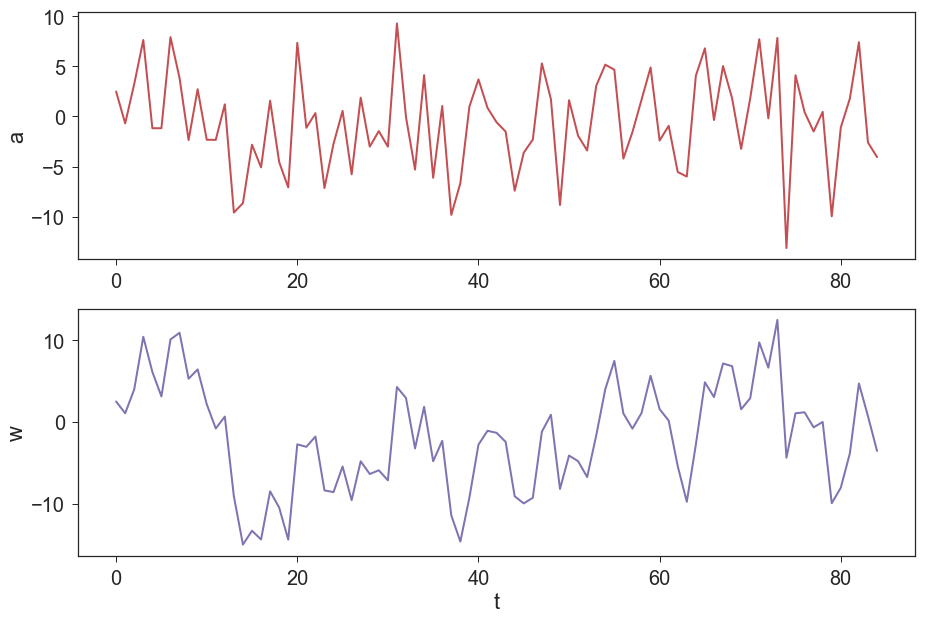

In [8]:
ph = np.array([.7]) # AR(1)
T = 85
sigma = 5
w1,a1 = sim_AR(phi=ph,sig=sigma,N=T,seed=42)
fig, axes = plt.subplots(2, 1, figsize=(15,10))
ax_a, ax_w = axes
ax_a.plot(a1, color=red, lw=2); ax_a.set_ylabel('a')
ax_w.plot(w1, color=purple, lw=2); ax_w.set(ylabel='w', xlabel='t');

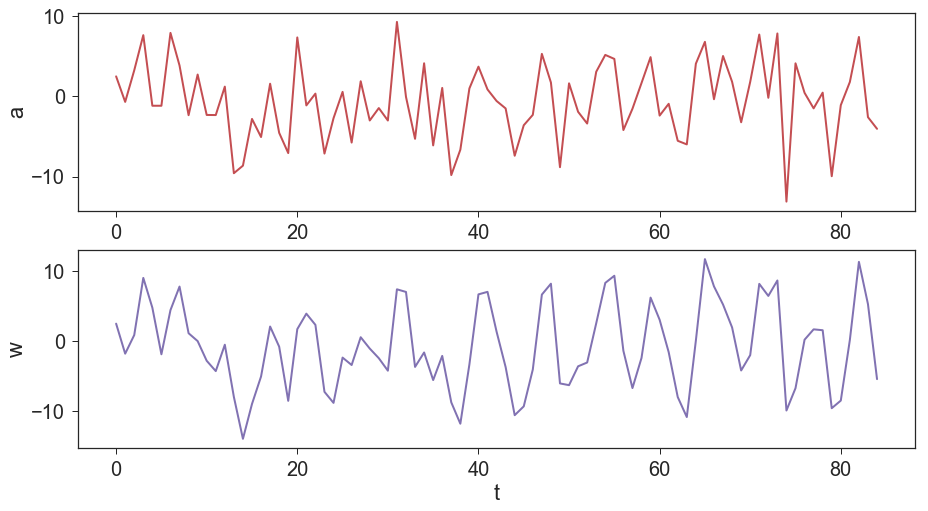

In [9]:
ph = np.array([.7,-.45]) # AR(2)
T = 85
sigma = 5
w1,a1 = sim_AR(phi=ph,sig=sigma,N=T,seed=42)
fig, axes = plt.subplots(2, 1, figsize=(15,8))
ax_a, ax_w = axes
ax_a.plot(a1, color=red, lw=2); ax_a.set_ylabel('a')
ax_w.plot(w1, color=purple, lw=2); ax_w.set(ylabel='w', xlabel='t');

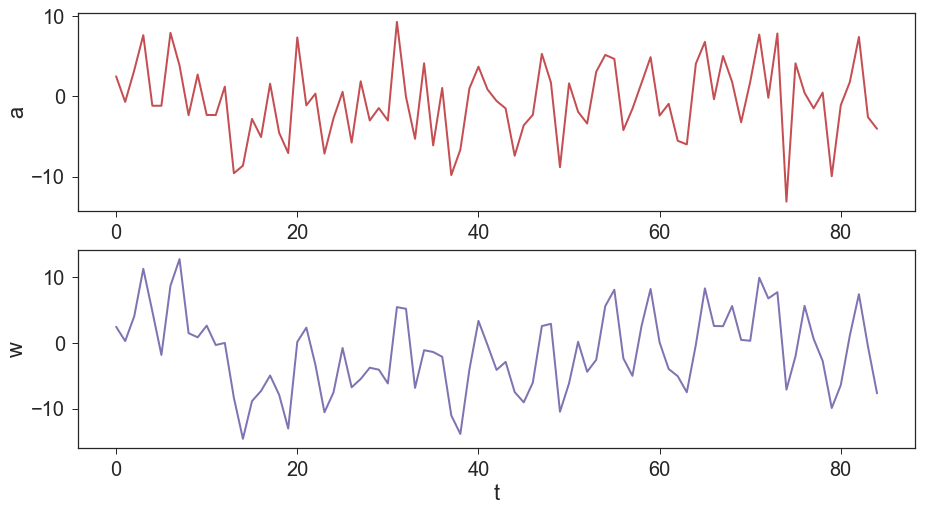

In [10]:
ph = np.array([.7,-.5,.4]) # AR(3)
T = 85
sigma = 5
w1,a1 = sim_AR(phi=ph,sig=sigma,N=T,seed=42)
fig, axes = plt.subplots(2, 1, figsize=(15,8))
ax_a, ax_w = axes
ax_a.plot(a1, color=red, lw=2); ax_a.set_ylabel('a')
ax_w.plot(w1, color=purple, lw=2); ax_w.set(ylabel='w', xlabel='t');

### Some statistical properties of AR processes

The autocovariance of an AR(p) process is given by:

$\gamma_k = \phi_1\gamma_{k-1} + \phi_2\gamma_{k-2} + \cdots + \phi_p\gamma_{k-p}$

And the autocorrelation is given by:

$\rho_k = \phi_1\rho_{k-1} + \phi_2\rho_{k-2} + \cdots + \phi_p\rho_{k-p}$

Note that these are the same $\phi$ coefficients as in the equation for the auto-regression model itself.

The power (squared magnitude) spectrum of an AR(p) process is given by:

$p(f) = \displaystyle{\frac{2\sigma^2_a}{\lvert 1-\phi_1 e^{-i\omega} - \phi_2 e^{-2i\omega} + \cdots + \phi_p e^{-ip\omega}\lvert^2}}$

### Observed and theoretical autocorrelation functions and power spectra for AR(1) processes

For the AR(1) process, theoretically, $\rho_k = \phi^k$, and the spectrum is:

$p(f) = \displaystyle{\frac{2\sigma^2_a}{\lvert 1-\phi e^{-i\omega}\lvert^2}}$

Here is an AR(1) sequence, along with the theoretical and observed autocorrelation functions for it:

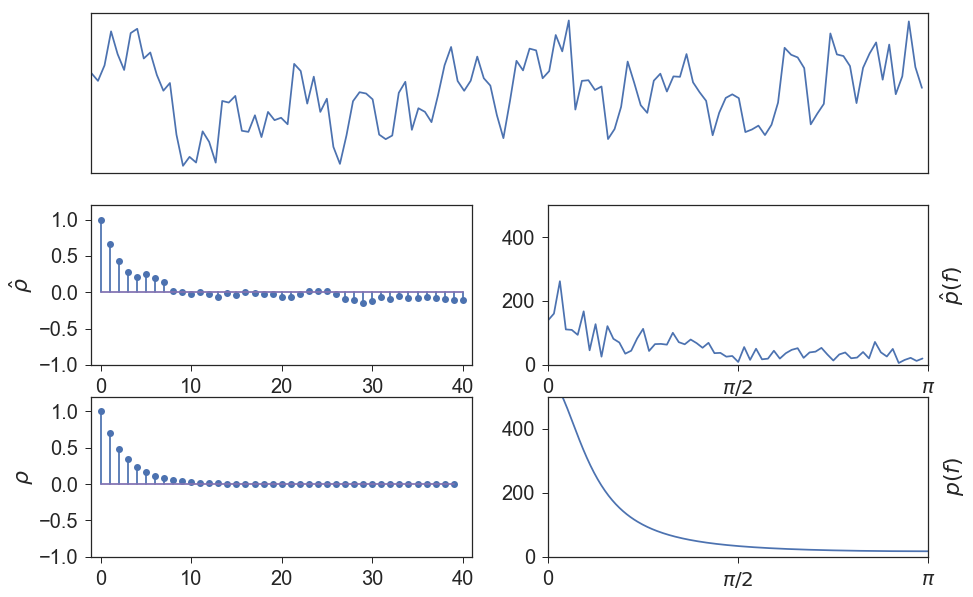

In [16]:
ph = np.array([.7]) # phi coefficient
T = 128 # number of samples
sigma = 5
w1,a1 = sim_AR(ph,sigma,T,42)
# theoretical autocorrelation
rh = np.array([ph**k for k in range(40)])
# observed autocorrelation
rh_obs = sm.tsa.acf(w1,nlags=40)
# theoretical spectrum
om = np.arange(0,np.pi+.01,.01)
pf = 2*sigma**2/np.absolute(1-ph*np.exp(-1j*om))**2
# observed spectrum
pf_obs = np.absolute(fft(w1)[:int(T/2)])

# plot stuff
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3,2)
ax1 = plt.subplot(gs[0,:]); ax2 = plt.subplot(gs[1,:1]); ax3 = plt.subplot(gs[1,1:]);
ax4 = plt.subplot(gs[2,:1]); ax5 = plt.subplot(gs[2,1:]);
ax1.plot(w1); ax1.set_xlim(0,T); ax1.set_xticks([]); ax1.set_yticks([]); # w
ax2.stem(rh_obs); ax2.set(xlim=(-1,41), yticks=np.linspace(-1,1,5), ylim=(-1,1.2), ylabel=r'$\hat{\rho}$');
ax4.stem(rh); ax4.set(xlim=(-1,41), yticks=np.linspace(-1,1,5), ylim=(-1,1.2), ylabel=r'$\rho$');
ax3.plot(np.arange(0,np.pi,2*np.pi/T),pf_obs)
ax3.set(xlim=(0,np.pi), ylim=(0,500), ylabel=r'$\hat{p}(f)$');
ax3.set_xticks([0,np.pi/2,np.pi]); ax3.set_xticklabels(['0','$\pi/2$','$\pi$']);
ax5.plot(om,pf);
ax5.set(xlim=(0,np.pi), ylim=(0,500), xticks=[0,np.pi/2,np.pi],
        xticklabels=['0','$\pi/2$','$\pi$'], ylabel=r'$p(f)$')
ax3.yaxis.set_label_coords(1.1,.5); ax5.yaxis.set_label_coords(1.1,.5)

### The partial autocorrelation function

The partial autocorrelation function for lag $k$ for an autoregressive process measures the correlation between $w_t$ and $w_{t-k}$ after adjusting for $w_{t-1}, w_{t-2}, \dots, w_{t-k+1}$ (i.e., it measures the correlation between $w_t$ and $w_{t-k}$ that is not accounted for by $w_{t-1}, w_{t-2}, \dots, w_{t-k+1}$).

The partial autocorrelation function is useful in large part because it provides information about the order of an autoregressive process. If we are fitting an AR model, we can use the partial autocorrelation function to help narrow down the range of reasonable values of $p$ to try. More specifically, the partial autocorrelation function for an AR(p) process is zero for $k > p$. Of course, because variation in the data will produce variation in the estimated model coefficients, this theoretical property won't hold exactly in typical real-world cases.

We can simulate AR(1) and AR(2) data, get the observed partial autocorrelation functions for the simulated data, and see how this variation manifests itself:

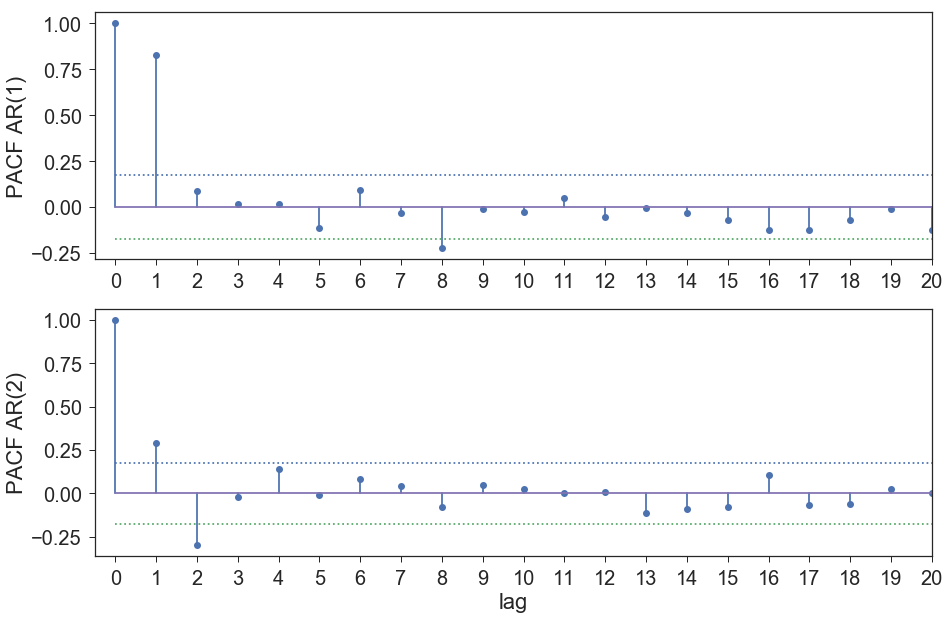

In [20]:
w1,a1 = sim_AR(np.array([.8]),sigma,T) # AR(1)
w2,a2 = sim_AR(np.array([.6,-.4]),sigma,T) # AR(2)
pacf_1 = sm.tsa.pacf(w1,nlags=20)
pacf_2 = sm.tsa.pacf(w2,nlags=20)
se = 1/np.sqrt(T)
fig, axes = plt.subplots(2, 1, figsize=(15,10)); ax1, ax2 = axes
ax1.stem(pacf_1); ax1.plot([0,20],2*se*np.ones(2),':'); ax1.plot([0,20],-2*se*np.ones(2),':');
ax1.set(xlim=(-.5,20), ylabel='PACF AR(1)', xticks=np.arange(21));
ax2.stem(pacf_2); ax2.plot([0,20],2*se*np.ones(2),':'); ax2.plot([0,20],-2*se*np.ones(2),':');
ax2.set(xlim=(-.5,20), ylabel='PACF AR(2)', xticks=np.arange(21), xlabel='lag');

### Moving average processes

A moving average process of order $q$ - MA(q) - is given by:

$w_t = a_t - \theta_1 a_{t-1} - \theta_2 a_{t-2} - \cdots - \theta_q a_{t-q}$

The autocorrelation function for an MA(q) process for $k \leq q$ is:

$\rho_k = \displaystyle{\frac{-\theta_k + \theta_1\theta_{k+1} + \cdots + \theta_{q-k}\theta_q}{1 + \theta_k^2 + \cdots + \theta_q^2}}$

The autocorrelation function for an MA(q) process for $k > q$ is zero. So, much like the **partial** autocorrelation function for AR(p) processes provides information about the value of $p$, the autocorrelation function for a MA(q) process provides information about the value of $q$.

The spectrum of an MA(q) process is given by:

$p(f) = 2\sigma^2_a \lvert 1 - \theta_1 e^{-i\omega} - \theta_2 e^{-2i\omega} - \cdots - \theta_q e^{-qi\omega}\lvert^2$

### The MA(1) process

The first order moving average process is given by:

$w_t = a_t - \theta a_{t-1}$

The autocorrelation function for $k=1$ is (it's zero for $k > 1$):

$\rho_1 = \displaystyle{\frac{-\theta}{1+\theta^2}}$

And the spectrum is:

$p(f) = 2\sigma^2_a\lvert 1 - \theta e^{-i\omega} \lvert^2$

We can simulate MA(q) data to see how observed and theoretical autocorrelation functions and spectra relate to one another:

In [21]:
def sim_MA(th,sig,N,seed=None):
    """th = theta coefficient(s)
       sig = sigma; scale of white noise input
       N = number of samples"""
    if seed:
        np.random.seed(seed=seed)
    a = np.random.normal(0,sig,N)
    ht = np.concatenate((-th[::-1],np.array([1])))
    w = np.zeros(N)
    q = len(ht)
    for i in range(N):
        beg = np.max([i-q,0])
        end = i
        w[i] = ht[:end] @ a[beg:end]
    return w, a

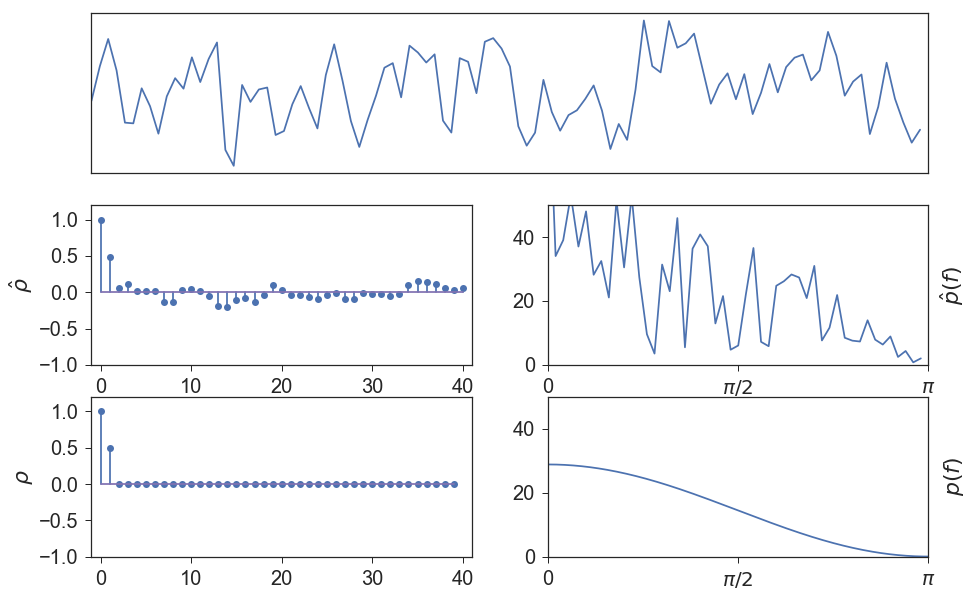

In [22]:
theta = np.array([-.9])
T = 100
sigma = 2
w1,a1 = sim_MA(theta,sigma,T,519)

nlag = 40

# theoretical autocorrelation
rh = np.zeros(nlag)
rh[0] = 1; rh[1] = -theta/(1+theta**2)
# observed autocorrelation
rh_obs = sm.tsa.acf(w1,nlags=40)
# theoretical spectrum
om = np.arange(0,np.pi+.01,.01)
pf = 2*sigma**2*np.absolute(1-theta*np.exp(-1j*om))**2
# observed spectrum
pf_obs = np.absolute(fft(w1)[:int(T/2)])

# plot stuff
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3,2)
ax1 = plt.subplot(gs[0,:]); ax2 = plt.subplot(gs[1,:1]); ax3 = plt.subplot(gs[1,1:]);
ax4 = plt.subplot(gs[2,:1]); ax5 = plt.subplot(gs[2,1:]);
ax1.plot(w1); ax1.set_xlim(0,T); ax1.set_xticks([]); ax1.set_yticks([]); # w
ax2.stem(rh_obs); ax2.set(xlim=(-1,41), yticks=np.linspace(-1,1,5), ylim=(-1,1.2), ylabel=r'$\hat{\rho}$');
ax4.stem(rh); ax4.set(xlim=(-1,41), yticks=np.linspace(-1,1,5), ylim=(-1,1.2), ylabel=r'$\rho$');
ax3.plot(np.arange(0,np.pi,2*np.pi/T),pf_obs); ax3.set(xlim=(0,np.pi), ylim=(0,50), ylabel=r'$\hat{p}(f)$');
ax3.set_xticks([0,np.pi/2,np.pi]); ax3.set_xticklabels(['0','$\pi/2$','$\pi$']);
ax5.plot(om,pf);
ax5.set(xlim=(0,np.pi), ylim=(0,50), xticks=[0,np.pi/2,np.pi],
        xticklabels=['0','$\pi/2$','$\pi$'], ylabel=r'$p(f)$')
ax3.yaxis.set_label_coords(1.1,.5); ax5.yaxis.set_label_coords(1.1,.5)

### ARMA(p,q) processes

It is common to combine AR(p) and MA(q) processes into a single model, the ARMA(p,q) process, which is similar to the general formulation for IIR filters we reviewed above:

$w_t = \phi_1 w_{t-1} + \phi_2 w_{t-2} + \cdots + \phi_p w_{t-p} + a_t - \theta_1 a_{t-1} - \theta_2 a_{t-2} - \cdots - \theta_q a_{t-q}$

The spectrum of an ARMA(p,q) process is given by:

$p(f) = \displaystyle{2\sigma^2_a\frac{\lvert 1-\theta_1 e^{-i\omega} - \cdots - \theta_q e^{-iq\omega} \lvert^2}{\lvert 1-\phi_1 e^{-i\omega} - \cdots - \phi_p e^{-ip\omega} \lvert^2}}$

We'll (maybe) look at the autocorrelation function for particular ARMA models below. For now, we'll simulate some ARMA(p,q) data:

In [23]:
def sim_ARMA(ph,th,sig,N,seed=None):
    """ph = phi coefficient(s)
       th = theta coefficient(s)
       sig = sigma; scale of white noise input
       N = number of samples"""
    if seed:
        np.random.seed(seed=seed)
    a = np.random.normal(0,sig,N)
    w = np.zeros(N)
    ht = np.concatenate((-th[::-1],np.array([1])))
    hp = ph[::-1]
    p = len(hp)
    q = len(ht)
    for i in range(N):
        beg_p = np.max([i-p,0])
        beg_q = np.max([i-q,0])
        end = i
        w[i] = hp[:end] @ w[beg_p:end] + ht[:end] @ a[beg_q:end]
    return w, a

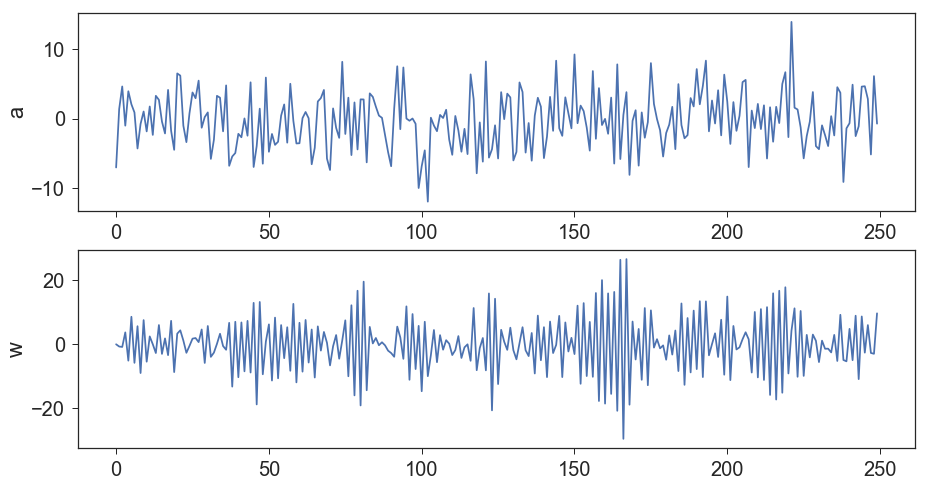

In [24]:
phi = np.array([-.6,.2]) # AR coefficients
theta = np.array([.4,-.1]) # MA coefficients
T = 250
sigma = 4
w_arma,a_arma = sim_ARMA(phi,theta,sigma,T,100)
fig, axes = plt.subplots(2, 1, figsize=(15,8)); ax_a, ax_w = axes
ax_a.plot(a_arma); ax_a.set(ylabel='a')
ax_w.plot(w_arma); ax_w.set(ylabel='w');

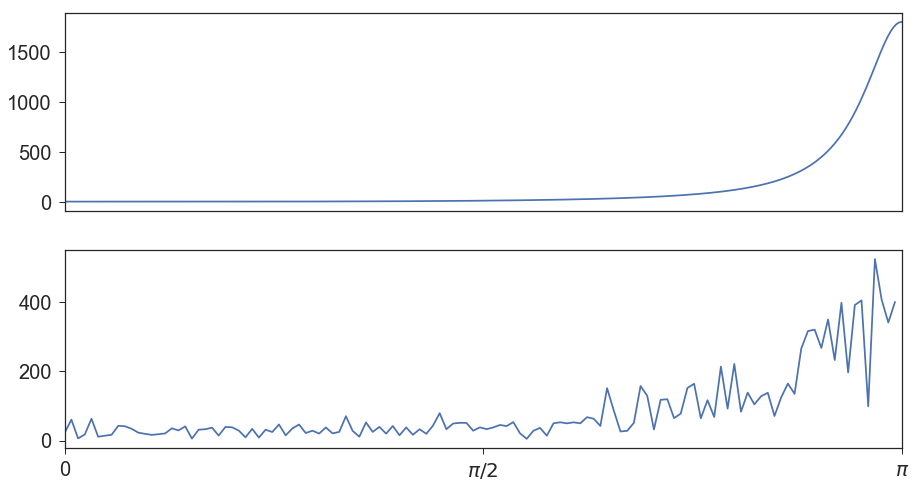

In [25]:
# theoretical spectrum
om = np.arange(0,np.pi+.01,.01)
num = -np.array([tt*np.exp(1j*(ti+1)*om) for ti,tt in enumerate(theta)]).sum(axis=0)
den = -np.array([pt*np.exp(1j*(pj+1)*om) for pj,pt in enumerate(phi)]).sum(axis=0)
pf = 2*sigma**2 * np.absolute(1+num)**2/np.absolute(1+den)**2
# observed spectrum
pf_obs = np.absolute(fft(w_arma)[:int(T/2)])
# plot stuff
fig, axes = plt.subplots(2, 1, figsize=(15,8)); ax_t, ax_o = axes
ax_t.plot(om,pf); ax_t.set_xlim(0,np.pi); ax_t.set_xticks([])
ax_o.plot(np.arange(0,np.pi,2*np.pi/T),pf_obs); ax_o.set_xlim(0,np.pi);
ax_o.set_xticks([0,np.pi/2,np.pi]); ax_o.set_xticklabels(['0','$\pi/2$','$\pi$']);

### Fitting an ARMA(p,q) model using the statsmodels module

As with regular linear regression, there are a number of convenient functions for fitting time series models. In particular, in **`sm.tsa`**, there is a function **`ARMA`** that behaves much like the linear regression function we saw before.

In order to estimate the order of the AR and MA components of the model, we can inspect the partial autocorrelation function (for the former; see, e.g., [Box et al Time Series Analysis: Forecasting and Control](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118619193) for a *lot* of detail about this and other methods to estimate the order of AR, MA, and ARMA models).

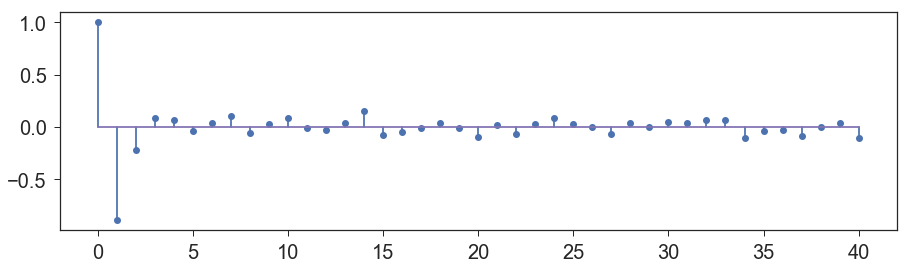

In [26]:
wc = w_arma - np.mean(w_arma)
wc_pacf = sm.tsa.pacf(wc)
fig, ax = plt.subplots(1, 1, figsize=(15,4))
_ = ax.stem(wc_pacf)

The partial autocorrelation function above suggests that one or maybe two coefficients are needed in an ARMA model fit to our time series. Because there is some uncertainty about this, we will fit models with one and two AR and MA coefficients and compare their performance.

In [28]:
# create ARMA(p,a) model object
arma_mod_22 = sm.tsa.ARMA(wc,(2,2)) # AR(2), MA(2)
arma_mod_21 = sm.tsa.ARMA(wc,(2,1)) # AR(2), MA(1)
arma_mod_12 = sm.tsa.ARMA(wc,(1,2)) # AR(1), MA(2)
arma_mod_11 = sm.tsa.ARMA(wc,(1,1)) # AR(1), MA(1)
# fit ARMA model object
arma_fit_22 = arma_mod_22.fit(trend='nc')
arma_fit_21 = arma_mod_21.fit(trend='nc')
arma_fit_12 = arma_mod_12.fit(trend='nc')
arma_fit_11 = arma_mod_11.fit(trend='nc')

# phi = np.array([-.6,.2]) # AR coefficients
# theta = np.array([.4,-.1]) # MA coefficients
print(arma_fit_22.arparams, arma_fit_22.maparams)
print(arma_fit_21.arparams, arma_fit_21.maparams)
print(arma_fit_12.arparams, arma_fit_12.maparams)
print(arma_fit_11.arparams, arma_fit_11.maparams)

[-1.00502192 -0.18479382] [-0.0637109   0.14633312]
[-1.30339565 -0.41978571] [ 0.22445899]
[-0.79565595] [-0.26705976  0.1718776 ]
[-0.84477493] [-0.20130659]


We can compare [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) and [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) statistics to see which model gets the best balance of fit and complexity:

In [29]:
print('    22       21       12       11')
print(np.round(np.array([arma_fit_22.aic,arma_fit_21.aic,arma_fit_12.aic,arma_fit_11.aic]),2))
print(np.round(np.array([arma_fit_22.bic,arma_fit_21.bic,arma_fit_12.bic,arma_fit_11.bic]),2))

    22       21       12       11
[ 1417.9   1417.73  1416.34  1419.83]
[ 1435.5   1431.81  1430.43  1430.4 ]


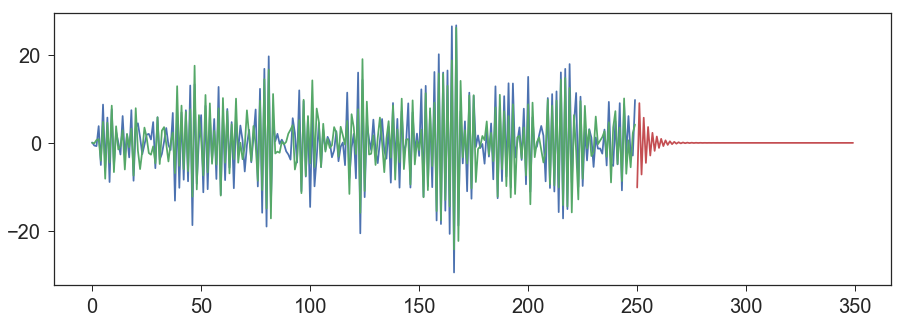

In [30]:
n_step=100
fc, fc_se, fc_ci  = arma_fit_12.forecast(steps=n_step)
w_hat = arma_fit_12.fittedvalues

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(wc)
ax.plot(w_hat)
ax.plot(np.arange(len(wc),len(wc)+n_step),fc);

### Fitting an ARMA model to real data.

We can import a time series set of air quality data from Beijing from the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data) and use some of the tools discussed above to analyze the data.

First, we can use pandas to read the data directly from the site:

In [31]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Next, we will add a `datetime` column to the data frame using the year, month, day, and hour columns (this takes a little while):

In [32]:
for i in df.index:
    df.loc[i,'date'] = pd.datetime(df.loc[i,'year'],df.loc[i,'month'],df.loc[i,'day'],df.loc[i,'hour'])

Now we can plot the air pressure column as a function of date:

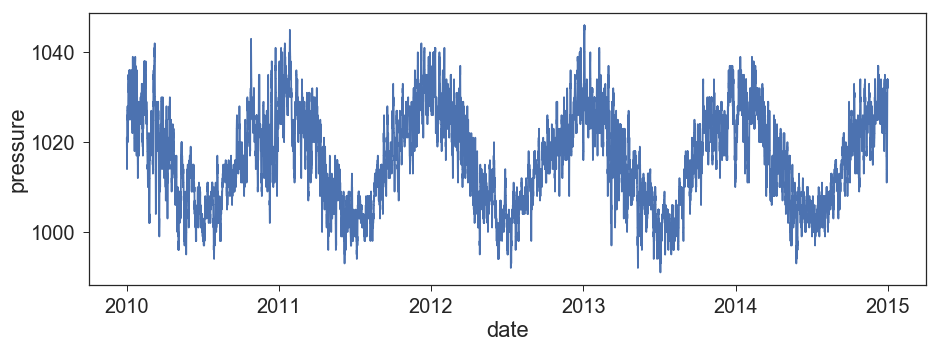

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(df['date'],df['PRES']); ax.set(ylabel='pressure', xlabel='date');

In order to make a first guess at how many coefficients to use in the fitted model, we can inspect the partial autocorrelation function. First, we'll center the data, then use the `date` variable as the index for the centered pandas `Series` object (this allows the `pacf()` function to do some useful stuff under the hood), then plot the pacf:

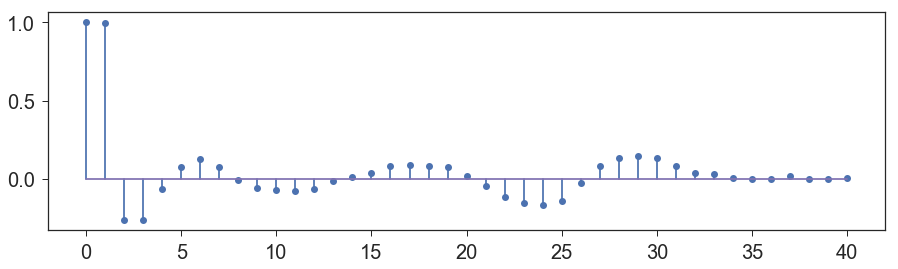

In [34]:
pres_c = df['PRES'] - df['PRES'].mean()
pres_c.index = df['date']
p_pacf = sm.tsa.pacf(pres_c)
fig, ax = plt.subplots(1, 1, figsize=(15,4))
_ = ax.stem(p_pacf)

Because there are three more or less obviously non-zero partial autocorrelation coefficients, we will fit a model with three AR and three MA coefficients:

In [35]:
arma_mod_33 = sm.tsa.ARMA(pres_c,(3,3))
arma_fit_33 = arma_mod_33.fit(trend='nc')

We can inspect the AR parameters by looking at the `arparams` property of the fitted model:

In [36]:
arma_fit_33.arparams

array([ 2.72090202, -2.70932379,  0.98776611])

And the MA parameters with the `maparams` property:

In [37]:
arma_fit_33.maparams

array([-1.62599711,  0.88927432,  0.0462891 ])

We can compare the original data to the fitted values (i.e., how closely the model approximates the data):

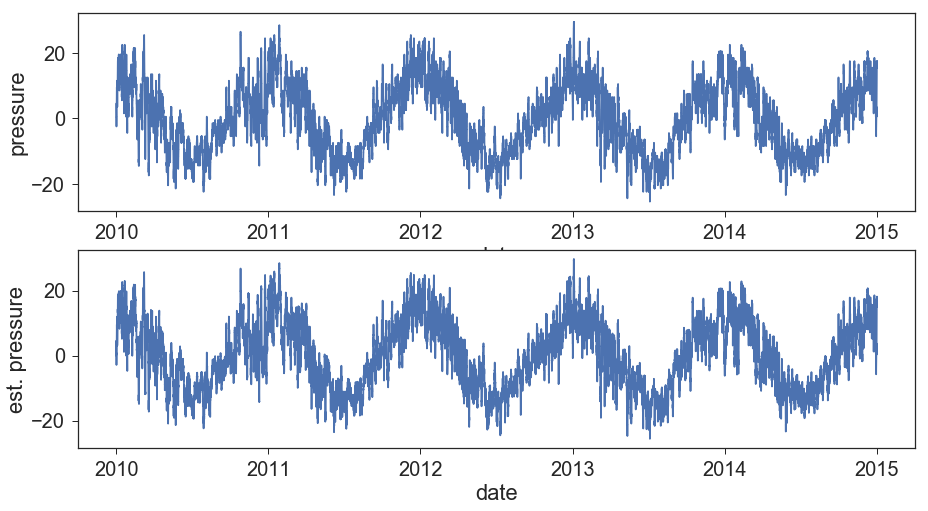

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(15,8))
axes[0].plot(df['date'],pres_c); axes[0].set(ylabel='pressure', xlabel='date');
axes[1].plot(df['date'],arma_fit_33.fittedvalues); axes[1].set(ylabel='est. pressure', xlabel='date');

We can do a spectral analysis of the fitted model using some of the tools described above:

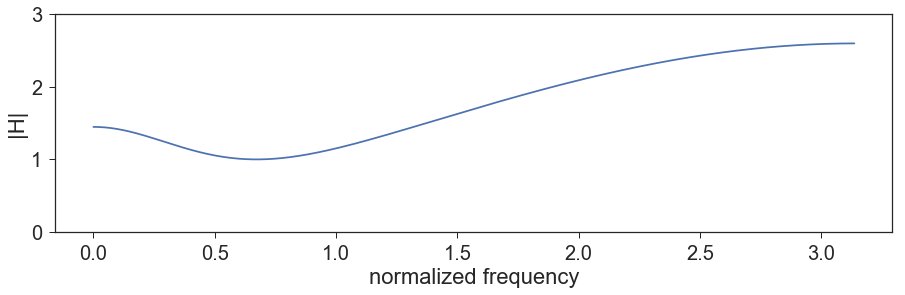

In [41]:
aa = arma_fit_33.arparams
bb = arma_fit_33.maparams
om, H_arma = freqz(aa,bb)

fig, ax = plt.subplots(1, 1, figsize=(15,4))
ax.plot(om, np.absolute(H_arma))
ax.set(xlabel='normalized frequency', ylabel='|H|', ylim=(0,3));

Note that the data were gathered hourly, so the period is one hour. Recall that the frequency is the reciprocal of the period, and that the highest frequency component that can be accurately represented in a periodically sampled signal is the Nyquist frequency, which is half of the sample frequency.

In this case, the fact that the sampling is once per hour means that the highest frequency component we can accurately represent would occur once per every two hours. So, the plot above indicates that the model is approximating the air pressure signal as some lower-magnitude low-frequency components (yearly and thereabouts) and a larger number of higher-magnitude high-frequency components (maybe monthly, probably weekly, daily, hourly).

We can also use the model to predict (forecast) future air pressure. We will create an extension of the `date` variable (but first we'll check to see what the last date in the data frame is):

In [42]:
df['date'][df.shape[0]-1]

Timestamp('2014-12-31 23:00:00')

The fitted model has a method for plotting predicted values (but it creates two axes for some reason):

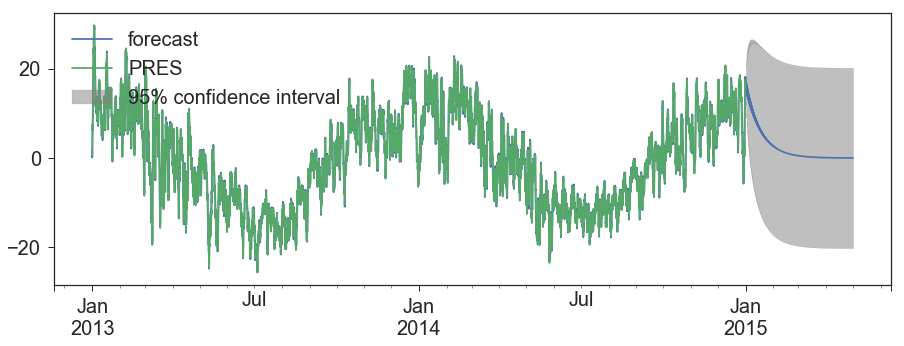

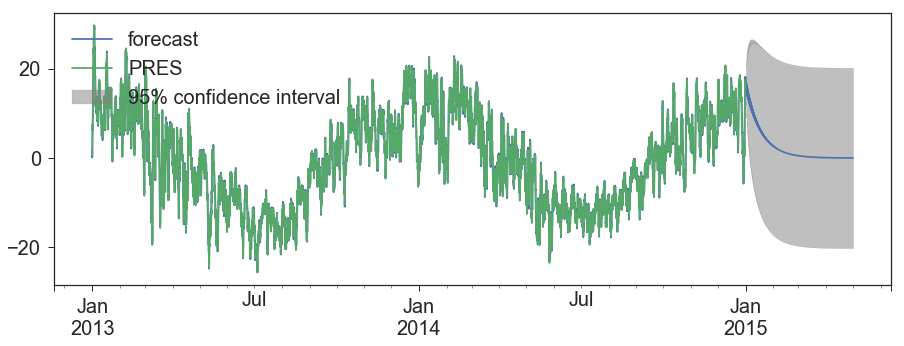

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
arma_fit_33.plot_predict(start=pd.datetime(2012,12,31,23), end=pd.datetime(2015,4,30,23), plot_insample=True, ax=ax)

We can also make our own prediction plot pretty easily:

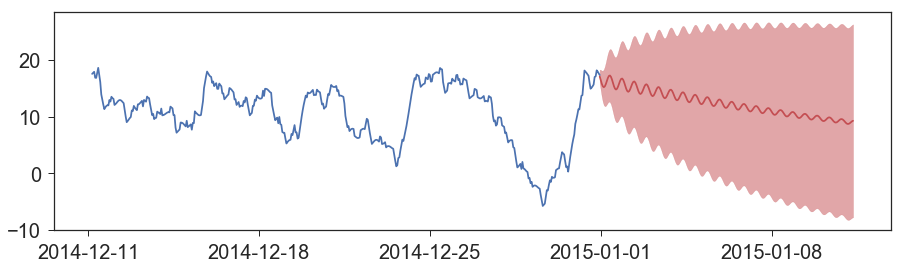

In [47]:
n_steps = 250
fc = arma_fit_33.forecast(steps=n_steps)
dt = pd.date_range(start=pd.datetime(2014,12,31,23), periods=n_steps, freq='H')
fig, ax = plt.subplots(1, 1, figsize=(15,4))
ax.plot(df['date'].values[-500:],arma_fit_33.fittedvalues[-500:])
ax.fill_between(y1=fc[2][:,0],y2=fc[2][:,1], x=dt, color=red, alpha=.5)
ax.plot(dt,fc[0],color=red);

## Summary

To be completed later...